# Hierarchical models for pack-ice seal abundance estimation
---

## Setup and EDA
---

In [85]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import geopandas as gpd
from theano.tensor.nnet.nnet import sigmoid, softplus
import pymc3 as pm
from arviz import from_pymc3, plot_trace, rhat        
from sklearn.preprocessing import scale

warnings.simplefilter('ignore')

sns.set_context('notebook')
plt.style.use('seaborn-darkgrid')


# read patch level data
data_patch = gpd.read_file('covariates/covariates_patch.dbf')

# read subpatch level data
data_subp = gpd.read_file('covariates/covariates_subp.dbf')

# reformat data
floe = np.array([np.sum(data_subp.loc[data_subp.patch_id == idx]['n_ice']) for idx in range(len(data_patch))])
N_ice = np.array([[np.sum(data_subp.loc[data_subp.patch_id == idx]['n_ice']) for idx in range(len(data_patch))]]).flatten()
N_ice_subp = np.array([np.array(data_subp.loc[data_subp.patch_id == idx]['n_ice']) for idx in range(len(data_patch))])
floe_subp = np.array([np.array(data_subp.loc[data_subp.patch_id == idx]['n_ice']) for idx in range(len(data_patch))])
cover = data_patch.sea_ice_co.values
n_patches, n_subp = floe_subp.shape

# show column stats for patches
data_patch.describe()



,patch_id,sea_ice_co
count,806.000000,806.000000
mean,402.500000,0.042859
std,232.816451,0.087546
min,0.000000,0.000000
25%,201.250000,0.000000
50%,402.500000,0.000537
75%,603.750000,0.047724
max,805.000000,0.997737


In [66]:
# show stats for subpatches
data_subp.describe()

,floe_size,n_ice,n_obs,patch_id,sea_ice_co
count,1.289600e+04,12896.000000,12896.000000,12896.000000,12896.000000
mean,5.722784e+03,0.218672,0.087857,402.500000,0.042859
std,8.863722e+04,1.188916,0.651509,232.681001,0.107359
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000,201.000000,0.000000
50%,0.000000e+00,0.000000,0.000000,402.500000,0.000000
75%,1.004744e+02,0.000000,0.000000,604.000000,0.030673
max,1.554231e+06,42.000000,17.000000,805.000000,1.000000


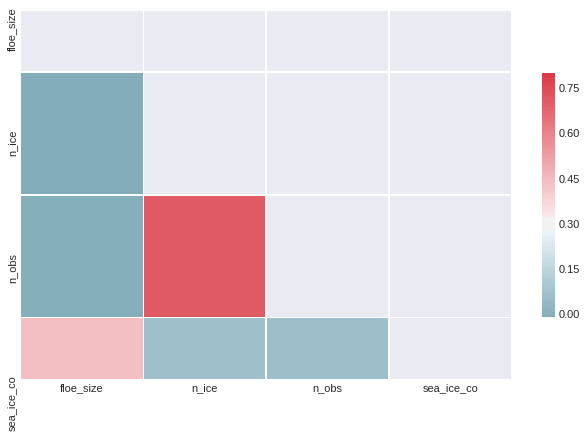

In [67]:
# Compute the correlation matrix for subpatches
corr = data_subp.drop(columns=['patch_id']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.8, center=0.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Model V0
---

* Total population and population on ice on patch scale.
* Fixed seal density ($\lambda_{\text{total}}$) and haul out probability ($\phi_{\text{haul}}$) across patches.
* Assumes no observer errors.

### Prior distributions for parameters
$$ \alpha_{\text{haul}} \sim \text{HalfNormal}(10)$$
$$ \beta_{\text{haul}} \sim \text{HalfNormal}(10)$$
$$ \lambda_{\text{total}} \sim \text{HalfNormal}(200)$$

### Posterior equations
$$ \phi_{\text{haul}} \sim \text{Beta}(\alpha_{\text{haul}}, \beta_{\text{haul}}) $$
$$ N_{\text{Total}[i]} \sim \text{Poisson}(\lambda_{\text{total}}) $$
$$ N_{\text{Ice}[i]} \sim \text{Binomial}(N_{\text{total}}, \phi_{\text{haul}})$$

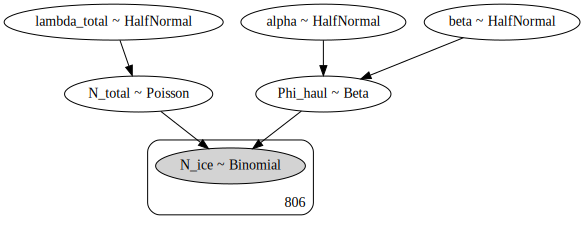

In [68]:
with pm.Model() as seals_model_v0:
    
    # priors for model parameters
    alpha = pm.HalfNormal('alpha', sd=10)
    beta = pm.HalfNormal('beta', sd=10)
    lambda_total = pm.HalfNormal('lambda_total', sd=200)
    
    # Fixed models
    phi_haul = pm.Beta('Phi_haul', alpha=alpha, beta=beta)
    N_total = pm.Poisson('N_total', mu=lambda_total)
    
    # likelihood function
    N_ice_pred = pm.Binomial('N_ice', n=N_total, p=phi_haul, observed=N_ice)
    
pm.model_to_graphviz(seals_model_v0)

In [69]:
# run model
with seals_model_v0:
    v0_trace = pm.sample(tune=10000, init='advi_map', n_init=100000, cores=3, draws=100000)

    
# inspect output
print(rhat(v0_trace))                                                           
v0_output = from_pymc3(v0_trace[::10])
pm.summary(v0_trace)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>NUTS: [Phi_haul, lambda_total, beta, alpha]
>Metropolis: [N_total]
Sampling 3 chains, 0 divergences: 100%|██████████| 330000/330000 [02:57<00:00, 1858.87draws/s]
The acceptance probability does not match the target. It is 0.42012176665823814, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898108294133034, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


<xarray.Dataset>
Dimensions:       ()
Data variables:
    N_total       float64 1.002
    alpha         float64 1.0
    beta          float64 1.0
    lambda_total  float64 1.002
    Phi_haul      float64 1.002


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f35f7388630>,
      dtype=object)

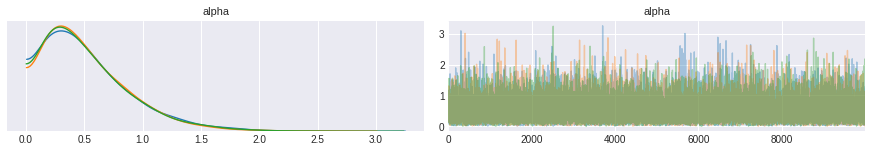

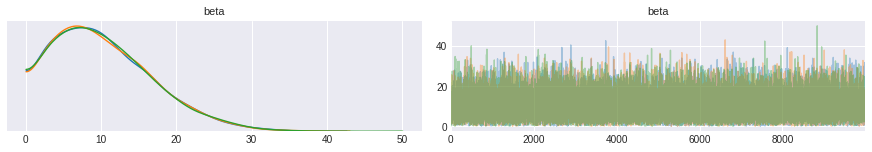

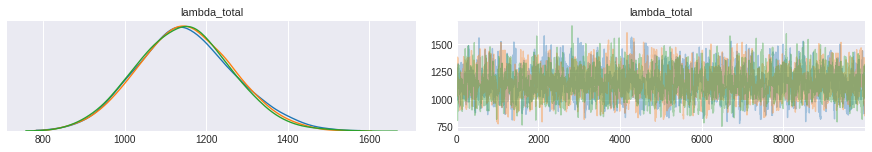

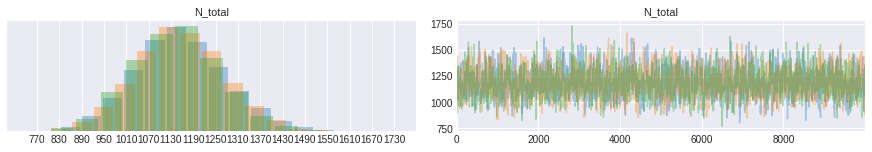

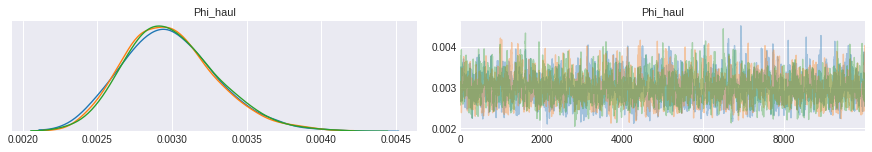

In [73]:
plot_trace(v0_output.posterior, var_names=['alpha'])
plot_trace(v0_output.posterior, var_names=['beta'])
plot_trace(v0_output.posterior, var_names=['lambda_total'])
plot_trace(v0_output.posterior, var_names=['N_total'])
plot_trace(v0_output.posterior, var_names=['Phi_haul'])

#### Posterior predictive checks with $N_{\text{Ice}}$

100%|██████████| 3000/3000 [00:01<00:00, 1847.50it/s]


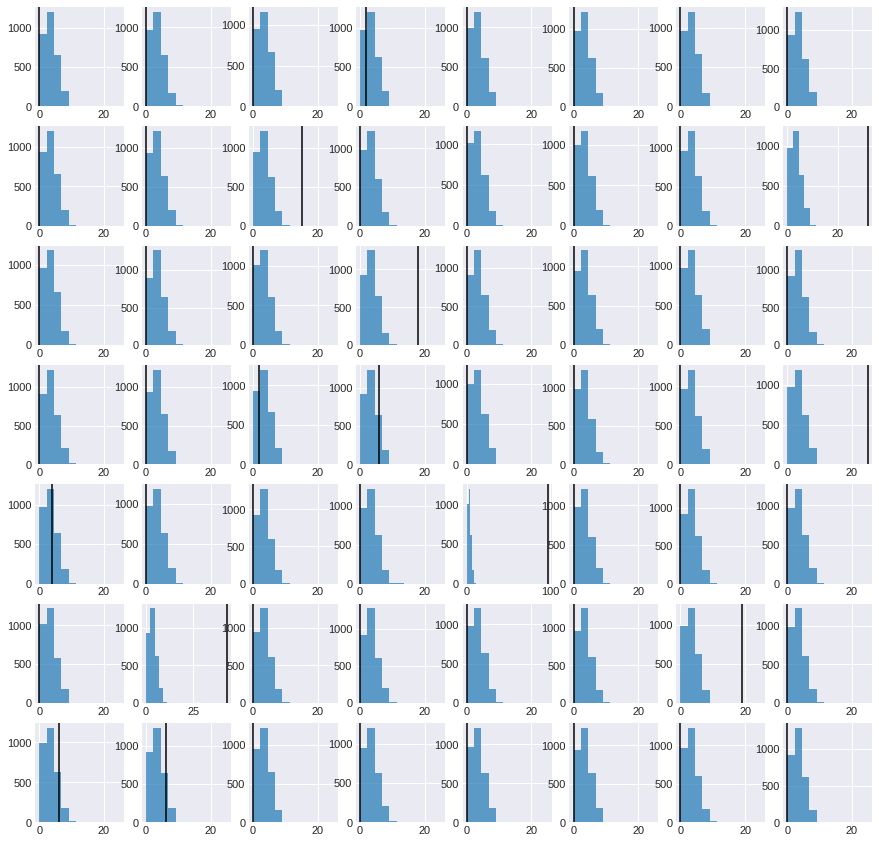

In [246]:
_, axs = plt.subplots(7, 8, figsize=[15, 15])
ppc = sample_posterior_predictive(v0_trace, samples=3000, model=seals_model_v0)
for idx, ele in enumerate (np.random.choice(range(len(N_ice)), 56)):
    N_ice_pred = [pred[ele] for pred in ppc['N_ice']]
    axs[idx % 7, idx // 7].hist(N_ice_pred, bins=11, alpha=0.7, range=(0, 25))
    axs[idx % 7, idx // 7].axvline(N_ice[ele], color='black')


## Model V1
* Total population and population on ice on patch scale.
* Seal density for patch *i* ($\lambda_{\text{total}[i]}$) depends on sea ice cover for that patch.
* Haul out probability for patch *i* ($\phi_{\text{haul}[i]}$) depends on floe size for that patch.
* Assumes no observer errors.

### Prior distributions for parameters
$$  a_{\text{cover}} \sim \text{HalfNormal}(300)$$
$$ b_{\text{cover}}  \sim \text{HalfNormal}(300)$$ 

$$ a_{\alpha \text{haul}} \sim \text{Normal}(0, 20)$$
$$ b_{\alpha \text{haul}} \sim \text{Normal}(0, 20)$$
$$ a_{\beta \text{haul}} \sim \text{Normal}(0, 20)$$
$$ b_{\beta \text{haul}} \sim \text{Normal}(0, 20)$$

### Deterministic functions
$$ \lambda_{\text{total[i]}} = a_{\text{cover}} * cover_{[i]} + b_{\text{cover}} $$
$$ \alpha_{\text{haul[i]}} = \text{Softplus}(a_{\alpha \text{haul}} * floe_{[i]} + (b_{\alpha \text{haul}}) $$
$$ \beta_{\text{haul[i]}} = \text{Softplus}(a_{\beta \text{haul}} * floe_{[i]} + (b_{\beta \text{haul}}) $$

### Posterior equations
$$ \phi_{\text{haul}[i]} \sim \text{Beta}(\alpha_{\text{haul}[i]}, \beta_{\text{haul}[i]}) $$
$$ N_{\text{Total}[i]} \sim \text{Poisson}(\lambda_{\text{total}[i]}) $$
$$ N_{\text{Ice}[i]} \sim \text{Binomial}(N_{\text{total}[i]}, \phi_{\text{haul}[i]})$$

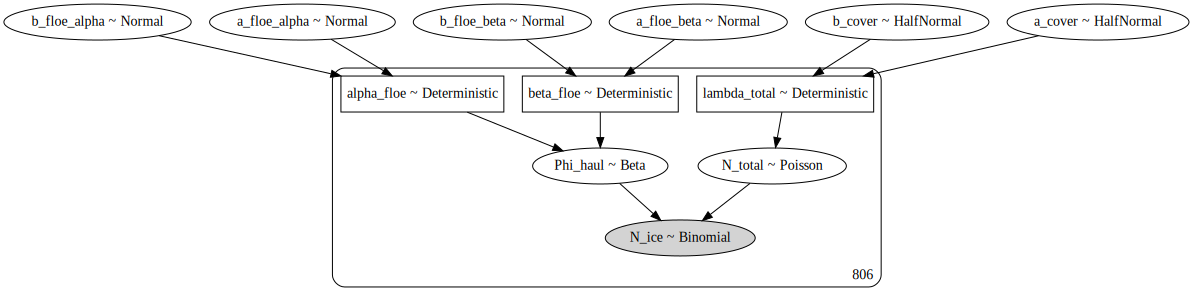

In [94]:

with pm.Model() as seals_model_v1:
    
    # priors for model parameters
    a_floe_alpha = pm.Normal('a_floe_alpha', mu=0, sd=10)
    b_floe_alpha = pm.Normal('b_floe_alpha', mu=0, sd=10)
    
    a_floe_beta = pm.Normal('a_floe_beta', mu=0, sd=10)
    b_floe_beta = pm.Normal('b_floe_beta', mu=0, sd=10)
    
    b_cover = pm.HalfNormal('b_cover', sd=500)
    a_cover = pm.HalfNormal('a_cover', sd=500)
    
    # deterministic functions
    lambda_total = pm.Deterministic('lambda_total', a_cover * cover + b_cover)
    alpha_floe = pm.Deterministic('alpha_floe', softplus(a_floe_alpha * floe + b_floe_alpha))
    beta_floe = pm.Deterministic('beta_floe', softplus(a_floe_beta * floe + b_floe_beta))
    
    # haul out probability for patch i
    phi_haul = pm.Beta('Phi_haul', alpha=alpha_floe, beta=beta_floe, shape=n_patches)
    
    # total number of seals for patch i
    N_total = pm.Poisson('N_total', mu=lambda_total, shape=n_patches)
    
    # likelihood function
    N_ice_pred = pm.Binomial('N_ice', n=N_total, p=phi_haul, observed=N_ice)
    
pm.model_to_graphviz(seals_model_v1)

In [ ]:
# run model
with seals_model_v1:
    v1_trace = pm.sample(tune=20000, draws=200000, init='advi', n_init=200000, cores=3, discard_tuned_samples=False)

    
# inspect output
print(rhat(v1_trace))                                                          
v1_output = from_pymc3(v1_trace[::10])
summary(v1_trace)

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>NUTS: [Phi_haul, a_cover, b_cover, b_floe_beta, a_floe_beta, b_floe_alpha, a_floe_alpha]
>Metropolis: [N_total]
Sampling 3 chains, 10,408 divergences: 100%|██████████| 660000/660000 [6:53:19<00:00, 26.61draws/s]  
There were 2235 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7302 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7171765722829999, but should be close to 0.8. Try to increase the number of tuning steps.
There were 871 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8930363922596566, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some paramete

In [ ]:
plot_trace(v1_output.posterior, var_names=['a_cover'])
plot_trace(v1_output.posterior, var_names=['b_cover'])
plot_trace(v1_output.posterior, var_names=['a_floe_alpha'])
plot_trace(v1_output.posterior, var_names=['b_floe_alpha'])
plot_trace(v1_output.posterior, var_names=['a_floe_beta'])
plot_trace(v1_output.posterior, var_names=['b_floe_beta'])
plot_trace(v1_output.posterior, var_names=['N_total'])

### Posterior predictive checks with $N_{\text{Ice}}$

100%|██████████| 3000/3000 [00:36<00:00, 82.87it/s]


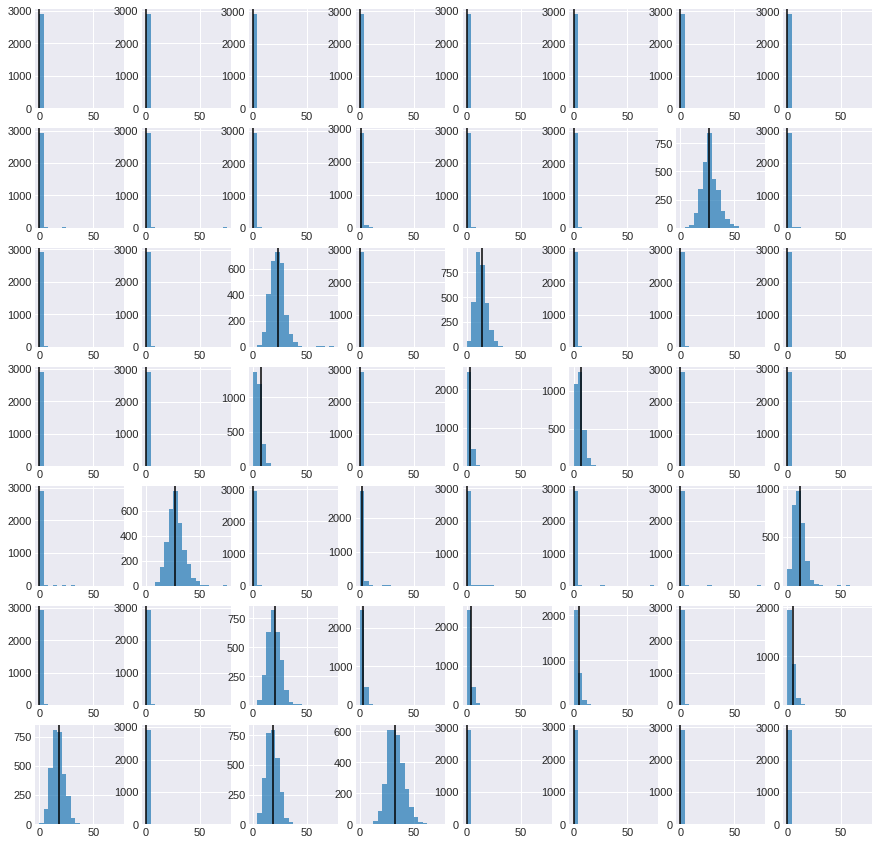

In [245]:
_, axs = plt.subplots(7, 8, figsize=[15, 15])
ppc = pm.sample_posterior_predictive(v1_trace, samples=3000, model=seals_model_v0)
for idx, ele in enumerate (np.random.choice(range(len(N_ice)), 56)):
    N_ice_pred = [pred[ele] for pred in ppc['N_ice']]
    axs[idx % 7, idx // 7].hist(N_ice_pred, bins=18, alpha=0.7, range=(0,75))
    axs[idx % 7, idx // 7].axvline(N_ice[ele], color='black')

## Model V2
---
* Total population ($N_{\text{Total}}$) on patch scale and seals on ice ($N_{\text{Ice}}$)  on subpatch scale.
* Seal density for patch *i* ($\lambda_{\text{total}[i]}$) depends on sea ice cover for that patch.
* Haul out probability for subpatch *i, j* ($\phi_{\text{haul}[i, j]}$) depends on floe size for that subpatch.
* Assumes no observer errors.

### Prior distributions for parameters
$$  a_{\text{cover}} \sim \text{HalfNormal}(300)$$
$$ b_{\text{cover}}  \sim \text{HalfNormal}(300)$$ 

$$ a_{\alpha \text{haul}} \sim \text{Normal}(0, 20)$$
$$ b_{\alpha \text{haul}} \sim \text{Normal}(0, 20)$$
$$ a_{\beta \text{haul}} \sim \text{Normal}(0, 20)$$
$$ b_{\beta \text{haul}} \sim \text{Normal}(0, 20)$$

### Deterministic functions
$$ \lambda_{\text{total[i]}} = a_{\text{cover}} * cover_{[i]} + b_{\text{cover}} $$
$$ \alpha_{\text{haul[i, j]}} = \text{Softplus}(a_{\alpha \text{haul}} * floe_{[i, j]} + (b_{\alpha \text{haul}}) $$
$$ \beta_{\text{haul[i, j]}} = \text{Softplus}(a_{\beta \text{haul}} * floe_{[i, j]} + (b_{\beta \text{haul}}) $$

### Posterior equations
$$ \phi_{\text{haul}[i, j]} \sim \text{Beta}(\alpha_{\text{haul}[i, j]}, \beta_{\text{haul}[i, j]}) $$
$$ N_{\text{Total}[i]} \sim \text{Poisson}(\lambda_{\text{total}[i]}) $$
$$ N_{\text{Ice}[i, (0 ... j)]} \sim \text{Multinomial}(N_{\text{Total}[i]}, \phi_{\text{haul}[i, (0 ... j)]})$$

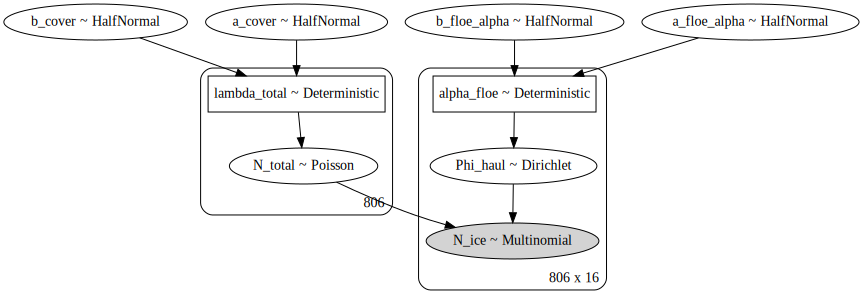

In [48]:
floe_subp = data_subp.floe_size.values
N_ice_subp = data_subp.N_ice_subp.values

with pm.Model() as seals_model_v2:
    
    # priors for model parameters
    a_floe_alpha = pm.HalfNormal('a_floe_alpha', sd=200)
    b_floe_alpha = pm.HalfNormal('b_floe_alpha', sd=200)
    
   # a_floe_beta = pm.Normal('a_floe_beta', mu=0, sd=100)
   # b_floe_beta = pm.Normal('b_floe_beta', mu=0, sd=100)
    
    b_cover = pm.HalfNormal('b_cover', sd=1000)
    a_cover = pm.HalfNormal('a_cover', sd=1000)
    
    # deterministic functions
    lambda_total = pm.Deterministic('lambda_total', a_cover * cover + b_cover)
    alpha_floe = pm.Deterministic('alpha_floe', a_floe_alpha * floe_subp + b_floe_alpha) 
    #beta_floe = softplus(a_floe_beta * floe_subp + b_floe_beta)
    
    # haul out probability for patch i
    phi_haul = pm.Dirichlet('Phi_haul', a=alpha_floe, shape=(n_patches, n_subp))
    
    # total number of seals for patch i
    N_total = pm.Poisson('N_total', mu=lambda_total, shape=n_patches)
    
    # likelihood function
    N_ice_pred = pm.Multinomial('N_ice', n=N_total, p=phi_haul, observed=N_ice_subp)
    
pm.model_to_graphviz(seals_model_v2)

In [50]:
# run model
for RV in seals_model_v2.basic_RVs:
    print(RV.name, RV.logp(seals_model_v2.test_point), seals_model_v2.test_point)
with seals_model_v2:
    v2_trace = pm.sample(tune=1000, init='jitter+adapt_diag', n_init=200000, cores=2, discard_tuned_samples=False)

    
# inspect output
print(rhat(v2_trace))                                                          
v1_output = from_pymc3(v2_trace[::15])


a_floe_alpha_log__ -0.7698925914732451 {'a_floe_alpha_log__': array(5.07252601), 'b_floe_alpha_log__': array(5.07252601), 'b_cover_log__': array(6.68196393), 'a_cover_log__': array(6.68196393), 'Phi_haul_stickbreaking__': array([[-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       ...,
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891]]), 'N_total': array([ 797,  797,  797,  797,  797,  797,  797,  797,  797,  797,  797,
        797,  797,  797,  797,  797,  797,  797,  797,  797,  797,  797,
       

Phi_haul_stickbreaking__ 17653.273113323034 {'a_floe_alpha_log__': array(5.07252601), 'b_floe_alpha_log__': array(5.07252601), 'b_cover_log__': array(6.68196393), 'a_cover_log__': array(6.68196393), 'Phi_haul_stickbreaking__': array([[-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       ...,
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891]]), 'N_total': array([ 797,  797,  797,  797,  797,  797,  797,  797,  797,  797,  797,
        797,  797,  797,  797,  797,  797,  797,  797,  797,  797,  797,
  

N_ice -inf {'a_floe_alpha_log__': array(5.07252601), 'b_floe_alpha_log__': array(5.07252601), 'b_cover_log__': array(6.68196393), 'a_cover_log__': array(6.68196393), 'Phi_haul_stickbreaking__': array([[-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       ...,
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891],
       [-0.01734243, -0.00080399,  0.01985881, ...,  0.07372211,
         0.01170099, -0.05285891]]), 'N_total': array([ 797,  797,  797,  797,  797,  797,  797,  797,  797,  797,  797,
        797,  797,  797,  797,  797,  797,  797,  797,  797,  797,  797,
        797,  797,  797,  797,  797

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [Phi_haul, a_cover, b_cover, b_floe_alpha, a_floe_alpha]
>Metropolis: [N_total]
Sampling 2 chains, 0 divergences:   0%|          | 0/3000 [00:00<?, ?draws/s]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
N_ice   -inf


ParallelSamplingError: Bad initial energy